### CiFAR 이미지 분류 모델 구현
- 데이터: ciFAR-10
- 학습 방법: 10가지 이미지 종류 분류 => 다중 분류
- 이미지: VGG16

In [1]:
from tensorflow import random # random seed 설정용
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt
import numpy as np

[1] 데이터 로딩 및 학습

In [2]:
(train_X, train_y), (test_X, test_y) = load_data()

In [3]:
train_X.shape, train_y.shape

((50000, 32, 32, 3), (50000, 1))

[2] 데이터 전처리 및 학습 형태로 변환

In [4]:
# 스케일링 => 픽셀/255.0
train_X = train_X/255.0
test_X = test_X/255.0

In [5]:
# 검증용 데이터 준비
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                  stratify=train_y,
                                                  random_state=11)

In [6]:
train_X.shape, val_X.shape

((37500, 32, 32, 3), (12500, 32, 32, 3))

[3] 모델 구성 및 생성

In [8]:
from tensorflow.keras.applications import vgg16

In [9]:
random.set_seed(11)

In [11]:
model = vgg16.VGG16(include_top=False, input_shape=(32,32,3))
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [12]:
remodel = Sequential()

In [13]:
remodel.add(model)

In [14]:
remodel.add(Dropout(0.5))

In [15]:
remodel.add(Flatten())

In [16]:
# 출력층 => Node: 10개(0~9), activation: softmax
remodel.add(Dense(10, activation='softmax')) # 1차원

In [17]:
remodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________________________


In [18]:
remodel.compile(loss='sparse_categorical_crossentropy',
              optimizer='SGD',
              metrics='accuracy')

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 검증 데이터에 대한 loss 값이 3번 연속 개선되지 않으면 학습 중지
stopCB = EarlyStopping(monitor='val_loss', patience=3)

In [22]:
hist = remodel.fit(train_X, train_y,
                 batch_size=20,
                 validation_data = (val_X, val_y),
                 epochs=10,
                 callbacks=[stopCB])

Epoch 1/10
1875/1875 [==============================] - 2010s 1s/step - loss: 1.0314 - accuracy: 0.6511 - val_loss: 0.6201 - val_accuracy: 0.7868
Epoch 2/10
1875/1875 [==============================] - 1937s 1s/step - loss: 0.5937 - accuracy: 0.7996 - val_loss: 0.5453 - val_accuracy: 0.8128
Epoch 3/10
1875/1875 [==============================] - 1950s 1s/step - loss: 0.4421 - accuracy: 0.8499 - val_loss: 0.5319 - val_accuracy: 0.8192
Epoch 4/10
1875/1875 [==============================] - 1956s 1s/step - loss: 0.3364 - accuracy: 0.8870 - val_loss: 0.5652 - val_accuracy: 0.8155
Epoch 5/10
1875/1875 [==============================] - 1918s 1s/step - loss: 0.2538 - accuracy: 0.9128 - val_loss: 0.4908 - val_accuracy: 0.8453
Epoch 6/10
1875/1875 [==============================] - 1888s 1s/step - loss: 0.1905 - accuracy: 0.9366 - val_loss: 0.5491 - val_accuracy: 0.8331
Epoch 7/10
1875/1875 [==============================] - 1855s 989ms/step - loss: 0.1422 - accuracy: 0.9519 - val_loss: 0.507

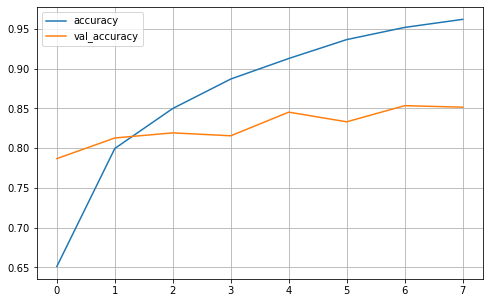

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xticks(hist.epoch)
plt.legend(['accuracy', 'val_accuracy'])
plt.grid()
plt.show()

[4] 평가

In [24]:
remodel.evaluate(test_X, test_y)

313/313 [==============================] - 63s 200ms/step - loss: 0.5458 - accuracy: 0.8481


[0.545843243598938, 0.8481000065803528]

[5] 새로운 데이터로 테스트

In [27]:
import PIL.Image as pilimg

In [41]:
# 새로운 사진 예측 함수
def pre_print(imagefile):
    pre_val=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

    # 이미지 불러오기
    test_image=pilimg.open(imagefile).resize((32,32))
    test_image_arr=np.array(test_image)

    # 이미지 그래프로 그리기
    plt.imshow(test_image)
    plt.show()

    # 예측
    result=np.round(remodel.predict(test_image_arr.reshape(-1,32,32,3)),2)
    print(f"""예측값: {result}\n종류: {pre_val[result.argmax()]}""")

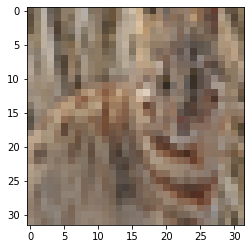

1/1 [==============================] - 0s 37ms/step
예측값: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
종류: frog


In [42]:
pre_print('삵.jfif')

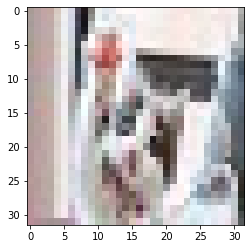

1/1 [==============================] - 0s 45ms/step
예측값: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
종류: dog


In [43]:
pre_print('고양이.jpg')

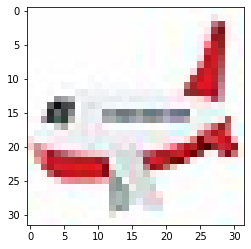

1/1 [==============================] - 0s 38ms/step
예측값: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
종류: airplane


In [44]:
pre_print('비행기.jpg')

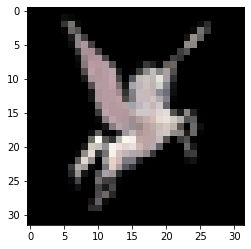

1/1 [==============================] - 0s 36ms/step
예측값: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
종류: airplane


In [45]:
pre_print('페가수스.jfif')

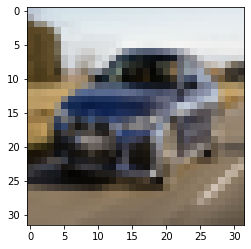

1/1 [==============================] - 0s 36ms/step
예측값: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
종류: automobile


In [46]:
pre_print('자동차.jfif')

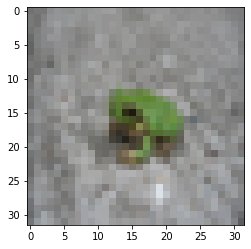

1/1 [==============================] - 0s 38ms/step
예측값: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
종류: frog


In [47]:
pre_print('개구리.jfif')

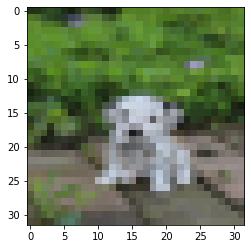

1/1 [==============================] - 0s 38ms/step
예측값: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
종류: dog


In [48]:
pre_print('강아지.jfif')